# Jupyter Notebook support

# Introduction

The notebook submodules (`immapp.nb` and `hello_imgui.nb`) provide convenient functions for the usage in a local jupyter notebook, with two main modes: 

* **blocking mode** (other cells cannot be run in parallel. A screenshot is displayed after the application exits)
* **non-blocking mode** (other cells can be run in parallel. The application window updates live)


:::{note}
_Note: Working on a remote notebook (or via Google Collab) may not work, since it requires a local X11 server (it might work if using X11 formwarding)._
:::

# Blocking mode

## API

`immapp.nb.run` and `hello_imgui.nb.run` functions will run a GUI application, wait for it to exit, and display a screenshot of the final application screen in the cell output.

_During the application execution, other cells cannot be run._

**Parameters**

`immapp.nb.run` and `hello_imgui.nb.run` accept the same parameters as `immapp.run` and `hello_imgui.run`, respectively.

Optional additional parameters to controls the screenshot size (choose only one of the two):
* thumbnail_ratio: (default=1.0)
  You can use it to change the size of the thumbnail. 
  Passing 0.5 will create a thumbnail half the width of the window.
* thumbnail_height: (default=0)
  You can use it to set a fixed height for the thumbnail (in pixels).
  If 0, the height is computed from the app window size.

## Example

The example cell below demonstrates the blocking mode using `immapp.nb.run`. It shows a sinusoidal curve that can be adjusted with a slider. After closing the application window, a screenshot of the final state is displayed in the cell output.

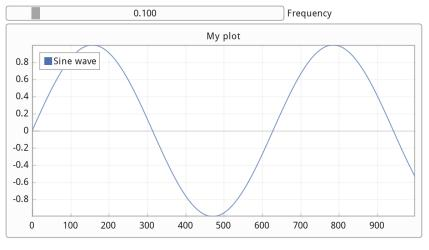

In [4]:
from imgui_bundle import implot, immapp, imgui
import numpy as np

FREQ = 0.1

def gui():
    global FREQ
    _, FREQ = imgui.slider_float("Frequency", FREQ, 0.01, 1.0)
    x = np.arange(0, 100, 0.1)
    y = np.sin(FREQ * x)
    if implot.begin_plot("My plot"):
        implot.plot_line("Sine wave", y)
        implot.end_plot()


immapp.nb.run(gui, window_size=(600, 350), with_implot=True, thumbnail_height=500)

# Non blocking mode

## API

### start
* `immapp.nb.start` and `hello_imgui.nb.start` will run a GUI application, display it in a top-most window on top of the browser.

**Other cells can be run while the application is running. The application window will update live.**

_Note: these function return an `asyncio.Task`, which may be awaited or managed using asyncio._

**Parameters**

`immapp.nb.start` and `hello_imgui.nb.start` accept the same parameters as `immapp.start` and `hello_imgui.start`, respectively.

Optional additional parameter: `top_most` to control if the application window should stay on top of other windows.

### is_running
* `immapp.nb.is_running` and `hello_imgui.nb.is_running` return True if the application is running, False otherwise.

### stop
* `immapp.nb.stop` and `hello_imgui.nb.stop` will stop the running application.

:::{tip}
Only one application can be run at a time from a notebook. Trying to start a new application while another one is running will exit the previous one.
:::

_Note: If other cells are running while the application is running, they should call `await asyncio.sleep(0)` periodically to allow the application to update._


:::{important}
If your GUI raises an exception, it might be difficult to trace with the GUI is running in an async way. 

In that case, it is recommended to first test your GUI in blocking mode using `immapp.nb.run`, which will propagate exceptions normally.
Once your GUI works in blocking mode, you can then switch to non-blocking mode (`immapp.nb.start`).
:::

## Example

### Start the application

The cell below demonstrates the non-blocking mode using `immapp.nb.start`. It runs the same application as before (a sinusoidal curve that can be adjusted with a slider). You can modify the frequency while the application is running by changing the value of the `FREQ` variable in another cell. 

When you run it, the cell exits immediately, but the GUI application continues to show and to be interactive (you can then run other cells while the application is running).

_Note: since, `immapp.nb.start` returns an `asyncio.Task`, you can see that the cell output shows the task information (Task pending, ...)._

:::{important}
In a non-blocking mode, the GUI will not be shown inside the notebook (not even as a screenshot). Instead, it will be displayed in a separate top-most window on top of the browser.

Refer to the "video demonstration" below for a demo of how the cells below will render on your screen.
:::

In [3]:
immapp.nb.start(gui, window_size=(500, 300), with_implot=True, top_most=True)

<Task pending name='Task-35' coro=<run_async() running at /Users/pascal/dvp/OpenSource/ImGuiWork/_Bundle/imgui_bundle/bindings/imgui_bundle/immapp/run_async_overloads.py:63>>

### Interact while the application is running

The cell below shows that it is possible to modify the frequency via code while the application is running, and the curve updates live.

In [4]:
FREQ = 0.5  # Modify frequency while the app is running

### Check if the application is running

The cells below can be used to check if the application is running

In [7]:
immapp.nb.is_running()

True

### Stop the application

In [8]:
immapp.nb.stop()

### Video demonstration

:::{figure} ../images/notebook_async.*
Demonstration of the non-blocking mode in a Jupyter notebook.
:::


# Example: Real-Time Data Stream Simulation

This example simulates a **live data stream** that continuously updates, like you might see in a monitoring dashboard or during ML training.

:::{tip}
Refer to the "video demonstration" below for a demo of how the cells below will render on your screen.
:::

## Start the GUI

The cell below instantiate the application data (stream_data) and starts a GUI application that displays the live data stream.

In [5]:
from imgui_bundle import immapp, imgui, hello_imgui, implot
import numpy as np
import time

# Streaming data buffer
stream_data = {
    "values": [],
    "max_points": 500,
    "paused": False
}

def streaming_gui():
    """GUI that shows a live streaming plot"""
    imgui.text("Live Data Stream")
    imgui.text(f"Points: {len(stream_data['values'])}")
    
    # Control buttons
    if imgui.button("Pause" if not stream_data["paused"] else "Resume"):
        stream_data["paused"] = not stream_data["paused"]
    
    imgui.same_line()
    if imgui.button("Clear"):
        stream_data["values"].clear()
    
    imgui.separator()
    
    # Plot the streaming data
    if len(stream_data["values"]) > 0:
        if implot.begin_plot("Data Stream", hello_imgui.em_to_vec2(40, 15)):
            x_data = np.arange(len(stream_data["values"]), dtype=np.float32)
            y_data = np.array(stream_data["values"], dtype=np.float32)
            implot.setup_axes("x", "y", implot.AxisFlags_.auto_fit, implot.AxisFlags_.auto_fit)
            implot.plot_line("Value", x_data, y_data)
            implot.end_plot()
    
    if imgui.button("Close"):
        hello_imgui.get_runner_params().app_shall_exit = True

# Start streaming GUI (note: immapp.nb.start is non-blocking 
# and immediately returns an asyncio task)
immapp.nb.start(
    streaming_gui,
    window_title="Data Stream Demo",
    window_size=(800, 400),
    with_implot=True,
    top_most=True
)

print("✓ Streaming GUI started!")
print("✓ Run the next cell to start the data stream.")

✓ Streaming GUI started!
✓ Run the next cell to start the data stream.


## Simulate Data Stream

The cell below simulates a data stream: this will add data points while the GUI displays them in real-time. 
* The GUI is already running above (in an asyncio task)
* So, we define another asyncio task to add data points (stream_data_loop below), and we run it in async way. 

This cell will run for 5 seconds: while it runs, you should see the GUI updating live with new data points.

:::{important}
It is important to call periodically `await asyncio.sleep(...)` in the loop, to yield control to the event loop, so that the GUI can update.
You may sleep for 0 seconds if you want to yield control with the shortest possible delay.
(in the example below, we sleep for 0.001 seconds to simulate a 100 Hz data stream).
:::

In [6]:
# 

import time
import random
import asyncio

async def stream_data_loop():
    print("Starting data stream... (will run for 10 seconds)")
    start_time = time.time()

    while time.time() - start_time < 5 and immapp.nb.is_running():
        if not stream_data["paused"]:
            # Add new data point
            new_value = np.sin(time.time()) + random.gauss(0, 0.1)
            stream_data["values"].append(new_value)
            
            # Keep buffer size limited
            if len(stream_data["values"]) > stream_data["max_points"]:
                stream_data["values"].pop(0)
        
        await asyncio.sleep(0.01) # Yield control to the event loop

    print(f"✓ Stream finished. Final count: {len(stream_data['values'])} points")

# Run the streaming loop
await stream_data_loop()

Starting data stream... (will run for 10 seconds)
✓ Stream finished. Final count: 492 points


## Video demonstration

:::{figure} ../images/notebook_datastream.*
Demonstration of the real-time data stream simulation in a Jupyter notebook.
:::


# Example: Real-Time AI Training and tuning

See [notebook_ml_training_async.ipynb](notebook_ml_training_async.ipynb) and [notebook_ml_training_threaded.ipynb](notebook_ml_training_threaded.ipynb) for complete examples of real-time neural network training and tuning using Dear ImGui Bundle in a Jupyter notebook.

